<a href="https://colab.research.google.com/github/benmsanderson/energybalance/blob/main/4xco2_bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
do_mcmc=0
do_pct=1
authdrive=1

Install some stuff

In [ ]:
!pip install --upgrade xarray zarr gcsfs cftime matplotlib==3.1.3 progress eofs netcdf4 >/dev/null
#!pip install https://github.com/matplotlib/basemap/archive/master.zip >/dev/null
!pip install lmfit corner emcee >/dev/null
!pip install nc-time-axis




Import stuff

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import nc_time_axis
from netCDF4 import num2date
import numpy as np
#import pydsm.relab as relab
import numpy.matlib
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import pickle
import cftime
#import cartopy.crs as ccrs
import dask as da
from eofs.xarray import Eof
from sys import getsizeof
from IPython.display import HTML, display
import time
import scipy
import lmfit
#import seaborn as sns
import emcee
import corner
from scipy import linalg
#from mpl_toolkits.basemap import Basemap



xr.set_options(display_style='html')

#code for pretty progress bars
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


Activate Google Drive to store arrays

In [ ]:
if authdrive:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Open xarray datasets

In [ ]:
#CMIP6
dslr_4x = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/dsall_4x_v2.nc")
dslr_cnt = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/dsall_cnt_v2.nc")

Define model names

In [ ]:
mdlslr=dslr_cnt.ens.model
family=dslr_cnt.ens.family
gens=['LongRunMIP','CMIP5','CMIP6']
nmlr=len(mdlslr)


In [ ]:
family

['LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'LongRunMIP',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP5',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6',
 'CMIP6']

Indexes of ensemble names

In [ ]:
findex0=[]
for j, gen in enumerate(gens):
  findex0.append([i for i, s in enumerate(family) if gen in s])


In [ ]:
findex0[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

**Define functions**

In [ ]:
def exporad(x, s1, s2, s3, t1, t2, t3, c):
    return s1*(np.exp(-x/t1))+s2*(np.exp(-x/t2))+s3*(np.exp(-x/t3))+c

In [ ]:
def linear(x, m, b):
    return m*x + b

In [ ]:
def expotas(x, s1, s2, s3, t1, t2, t3):
    return s1*(1-np.exp(-x/t1))+s2*(1-np.exp(-x/t2))+s3*(1-np.exp(-x/t3))

Anomaly timeseries relative to control means

In [ ]:
net_cnt=dslr_cnt.rsut+dslr_cnt.rlut-dslr_cnt.rsdt
net_4x=dslr_4x.rsut+dslr_4x.rlut-dslr_4x.rsdt

net_cnt_100=np.empty([len(mdlslr),1])
len4x=np.empty([len(mdlslr),1])

for i,j in enumerate(mdlslr):
  tmp=net_cnt[i,net_cnt[i,:].notnull()]
  net_cnt_100[i]=tmp[-500:].mean()
  tmp4=net_4x[i,net_4x[i,:].notnull()]
  len4x[i]=len(tmp4)
netanomlr=dslr_4x.rsut.copy(deep=True)*0
netcntlr=net_cnt.copy(deep=True)*0

for i,j in enumerate(mdlslr):
  netanomlr[i,:]=dslr_4x.rsut[i,:]+dslr_4x.rlut[i,:]-dslr_4x.rsdt[i,:]-net_cnt_100[i]
  netcntlr[i,:]=net_cnt[i,:]-net_cnt_100[i]
  

In [ ]:
ts_cnt_100=np.empty([len(mdlslr),1])

#TAS anomaly
for i,j in enumerate(mdlslr):
  tmp=dslr_cnt.tas[i,dslr_cnt.tas[i,:].notnull()]
  ts_cnt_100[i]=tmp[-500:].mean()
tsanomlr=dslr_4x.tas.copy(deep=True)*0
tscntlr=dslr_cnt.tas.copy(deep=True)*0

for i,j in enumerate(mdlslr):
  tsanomlr[i,:]=dslr_4x.tas[i,:]-ts_cnt_100[i]
  tscntlr[i,:]=dslr_cnt.tas[i,:]-ts_cnt_100[i]


In [ ]:
len(np.where(~np.isnan(tsanomlr[-1,:]))[0])
lents=[]
findex=[None] * 3
for j,phs in enumerate(findex0):
  findex[j]=[]
  for i,ii in enumerate(phs):
    lents.append(len(np.where(~np.isnan(tsanomlr[ii,:]))[0]))
    if lents[ii]>100:
      findex[j].append(ii)

In [ ]:
findex[0]=findex[0][1:]

In [ ]:
findex[0]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Fit 4xCO2 decays


In [ ]:
model = lmfit.Model(exporad)

exp_fparamslr=np.zeros((nmlr,7))
p = model.make_params(s1=10.,s2=10.,s3=10.,t1=1.,t2=50.,t3=1000.,c=0.)
p.add_many(('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',   5,  True,  0., 10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  150,  None),
           ('t3',  500, True, 100, 2000, None),
           ('c',  0, True, -5, 5,None))

result_lr=[None]*nmlr
t_pct=np.zeros((nmlr,3,10000))

if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for i, row in enumerate(mdlslr):
#  for i, row in enumerate(findex[0]):
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=p, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=1500, burn=500, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/result_lr.pickle", "wb")
  pickle.dump(result_lr, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/result_lr.pickle", "rb")
  result_lr= pickle.load(file_pkl)
  file_pkl.close()

if do_pct:
  for i, row in enumerate(mdlslr):
    print(i)
    result_emcee=result_lr[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    t_pct[i,:,:]=np.percentile(tdist,[10,50,90],1)
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct.pickle", "wb")
  pickle.dump(t_pct, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct.pickle", "rb")
  t_pct= pickle.load(file_pkl)
  file_pkl.close()
  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


Temperature

In [ ]:
model = lmfit.Model(expotas)
exp_tparamslr=np.zeros((nmlr,7))
pt = model.make_params(s1=10.,s2=10.,s3=10.,t1=1.,t2=50.,t3=1000.)
pt.add_many(('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',   5,  True,  0., 10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  150,  None),
           ('t3',  500, True, 150, 2000, None))

result_lt=[None]*len(mdlslr)
et_pct=np.zeros((len(mdlslr),3,10000))
etcr_pct=np.zeros((len(mdlslr),3))
et140_pct=np.zeros((len(mdlslr),3))
etcr35_pct=np.zeros((len(mdlslr),3))
pfit=np.zeros((len(mdlslr),3,7))

if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for i, row in enumerate(mdlslr):
  #for i in range(0,1):
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=1500, burn=500, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt[i]=result_emcee
    out.update(progress(i+1, nmlr))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/result_lt.pickle", "wb")
  pickle.dump(result_lt, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/result_lt.pickle", "rb")
  result_lt= pickle.load(file_pkl)
  file_pkl.close()


if do_pct:
  for i, row in enumerate(mdlslr):
    print(i)
    result_emcee=result_lt[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tcrdist=np.zeros((10000,len(result_emcee.flatchain)))
    pdist=np.zeros((7,len(result_emcee.flatchain)))
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      pdist[:,j]=ptmp
      p1 = model.make_params(s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      tcrdist[:,j]=scipy.signal.lfilter(np.ones([150]).T/140,1,tdist[:,j])
    pfit[i,:,:]=np.percentile(pdist,[5,50,95],1)
    et_pct[i,:,:]=np.percentile(tdist,[5,50,5],1)
    etcr_pct[i,:]=np.percentile(tcrdist[70,:],[5,50,95])
    etcr35_pct[i,:]=np.percentile(tcrdist[35,:],[5,50,95])
    et140_pct[i,:]=np.percentile(tcrdist[140,:],[5,50,95])
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/et_pct.pickle", "wb")
  pickle.dump(et_pct, file_pkl)
  file_pkl.close()
  with open('/content/drive/MyDrive/colab_4xco2/tcr.pkl', 'wb') as f: 
    pickle.dump([etcr_pct, et140_pct, pfit, etcr35_pct], f)
# Getting back the objects:
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/et_pct.pickle", "rb")
  et_pct= pickle.load(file_pkl)
  file_pkl.close()
  with open('/content/drive/MyDrive/colab_4xco2/tcr.pkl','rb') as f:
    etcr_pct, et140_pct, pfit, etcr35_pct = pickle.load(f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


Temperature (first 150 years only, longrunmip check)

In [ ]:
model = lmfit.Model(expotas)
exp_tparamslr=np.zeros((nmlr,7))
pt = model.make_params(s1=10.,s2=10.,s3=10.,t1=1.,t2=50.,t3=1000.)
pt.add_many(('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',   5,  True,  0., 10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  150,  None),
           ('t3',  500, True, 150, 2000, None))

result_ltc=[None]*nmlr
etc_pct=np.zeros((len(mdlslr),3,10000))
 
if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for i, row in enumerate(findex[0]):
  #for i in range(5,6):
    y_array=tsanomlr[i,:150]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=1500, burn=500, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_ltc[i]=result_emcee
    out.update(progress(i+1, len(findex[0])))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/result_ltc.pickle", "wb")
  pickle.dump(result_ltc, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/result_ltc.pickle", "rb")
  result_ltc= pickle.load(file_pkl)
  file_pkl.close()



In [ ]:

if do_pct:
  for i, row in enumerate(findex[0]):
  #for i in range(5,6):
    print(i)
    result_emcee=result_ltc[i]
    tdistc=np.zeros((10000,len(result_emcee.flatchain)))
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tdistc[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    etc_pct[i,:,:]=np.percentile(tdistc,[5,50,95],1)
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pct.pickle", "wb")
  pickle.dump(etc_pct, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pct.pickle", "rb")
  etc_pct= pickle.load(file_pkl)
  file_pkl.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
findex[0]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

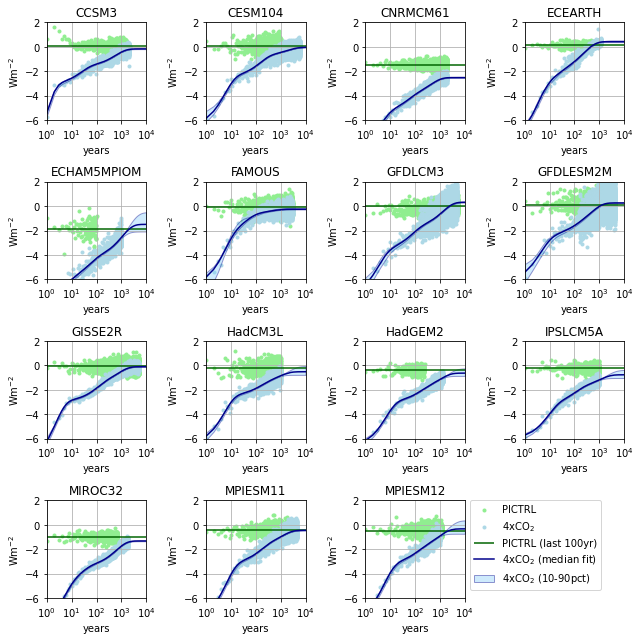

In [ ]:

fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(9)
fig.set_figwidth(9)



for j, i in enumerate(findex[0]):

  p3=axes[j].hlines(y=net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='-')

  y_array=net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen')
  y_array=net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p1=axes[j].scatter(x_array,y_array,color='lightblue',marker='.')

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-6,2])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-net_cnt_100[i],color='darkgreen')

  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),-t_pct[i,0,:],-t_pct[i,2,:],alpha=0.4,facecolor='lightskyblue',linestyle='-',ec='darkblue')
  p5=axes[j].plot(np.arange(1,10001),-t_pct[i,1,:],color='darkblue')

  
axes[15].set_visible(False)
plt.tight_layout()
axes[j].legend([p0,p1,p3,p5[0],p4], ['PICTRL','4xCO$_2$','PICTRL (last 100yr)','4xCO$_2$ (median fit)','4xCO$_2$ (10-90pct)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_lrmip.png", bbox_inches='tight')
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_lrmip.pdf", bbox_inches='tight')


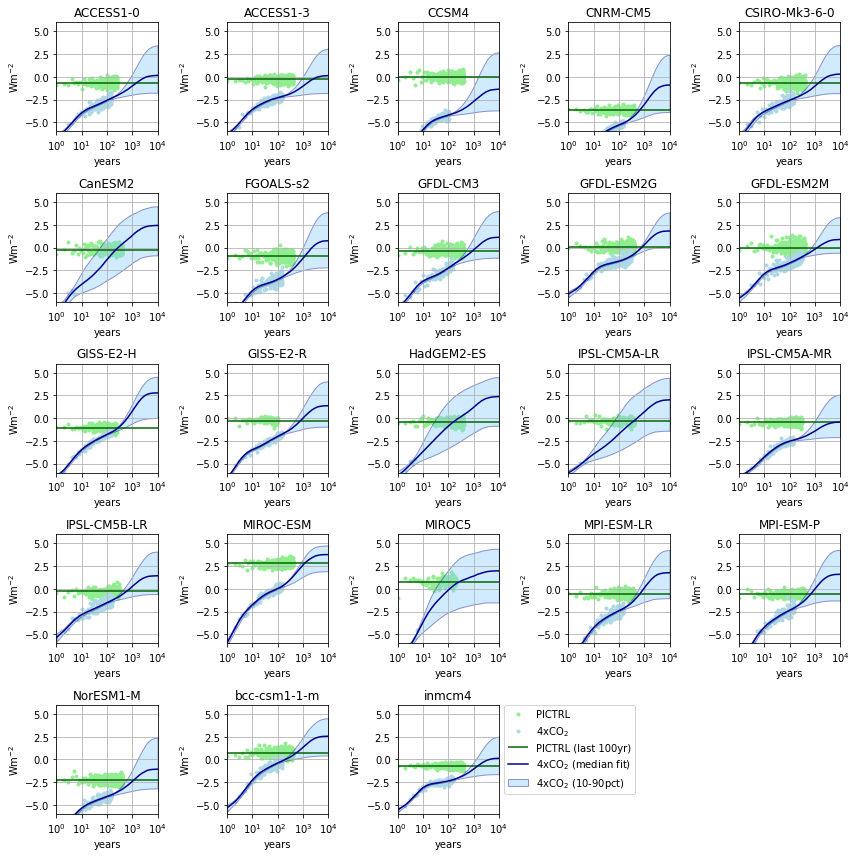

In [ ]:

fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(12)
fig.set_figwidth(12)



for j, i in enumerate(findex[1]):

  p3=axes[j].hlines(y=net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='-')

  y_array=net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen')
  y_array=net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p1=axes[j].scatter(x_array,y_array,color='lightblue',marker='.')

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-6,6])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-tc_pct[i,1,:],color='darkgreen')
  
  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),-t_pct[i,0,:],-t_pct[i,2,:],alpha=0.4,facecolor='lightskyblue',linestyle='-',ec='darkblue')
  p5=axes[j].plot(np.arange(1,10001),-t_pct[i,1,:],color='darkblue')

axes[23].set_visible(False)
axes[24].set_visible(False)
  
plt.tight_layout()
axes[j].legend([p0,p1,p3,p5[0],p4], ['PICTRL','4xCO$_2$','PICTRL (last 100yr)','4xCO$_2$ (median fit)','4xCO$_2$ (10-90pct)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_cmip5.png", bbox_inches='tight')

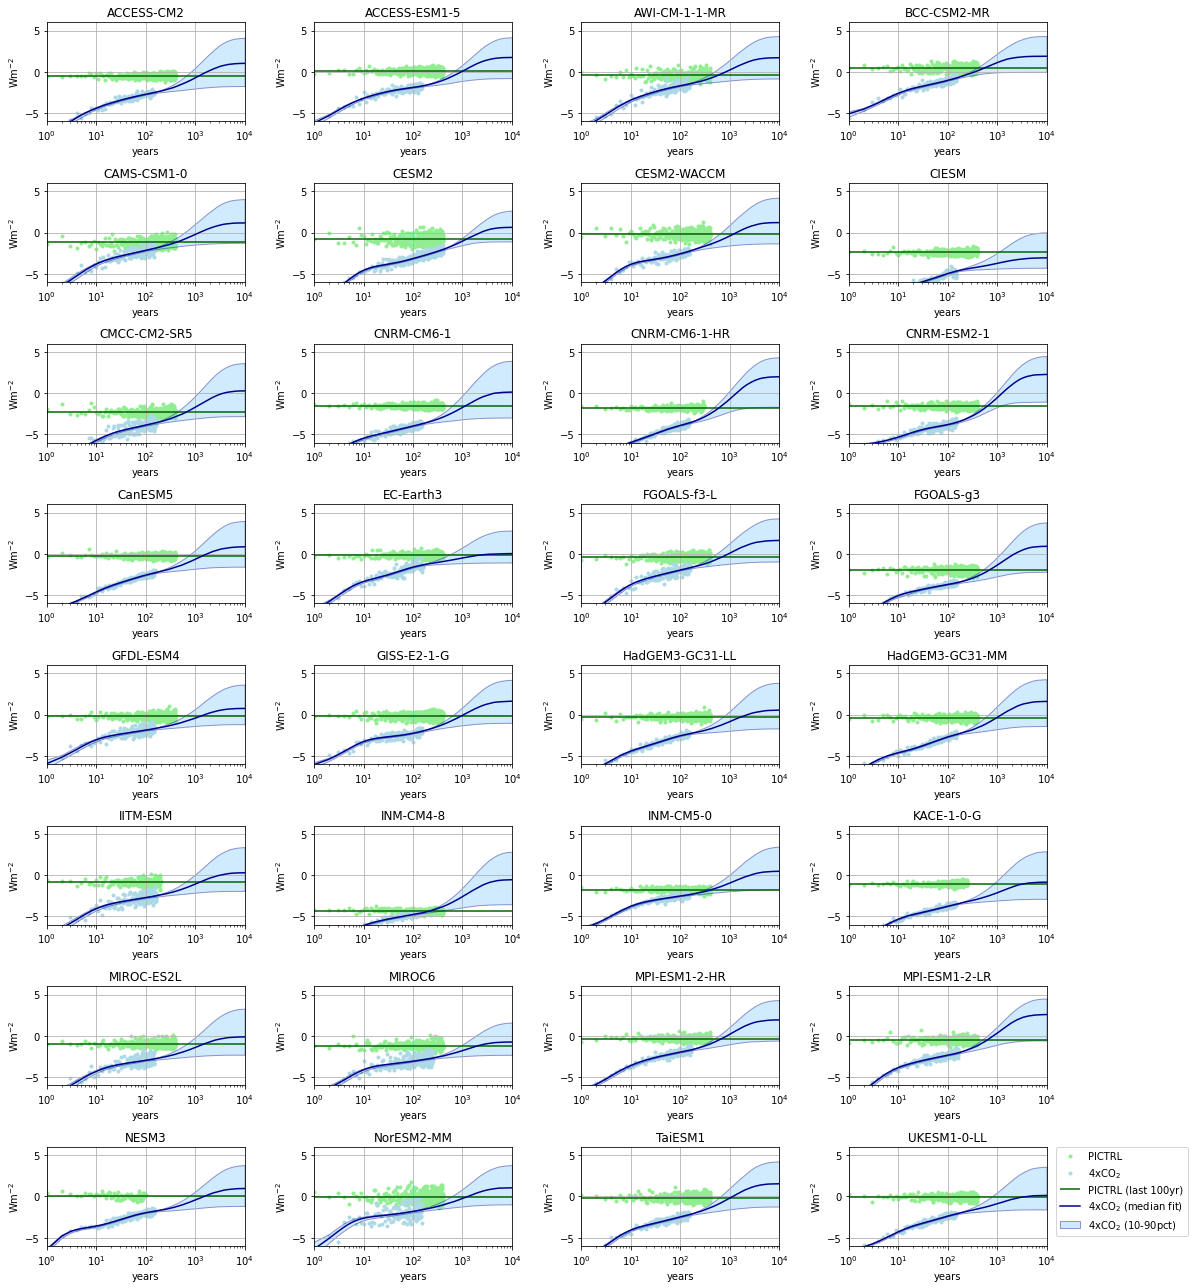

In [ ]:

fig, axes = plt.subplots(ncols=4,nrows=8)
axes = axes.flatten()

fig.set_figheight(18)
fig.set_figwidth(15)



for j, i in enumerate(findex[2]):

  p3=axes[j].hlines(y=net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='-')

  y_array=net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen')
  y_array=net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p1=axes[j].scatter(x_array,y_array,color='lightblue',marker='.')

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-6,6])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-tc_pct[i,1,:],color='darkgreen')
  
  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),-t_pct[i,0,:],-t_pct[i,2,:],alpha=0.4,facecolor='lightskyblue',linestyle='-',ec='darkblue')
  p5=axes[j].plot(np.arange(1,10001),-t_pct[i,1,:],color='darkblue')

  
  
plt.tight_layout()
axes[j].legend([p0,p1,p3,p5[0],p4], ['PICTRL','4xCO$_2$','PICTRL (last 100yr)','4xCO$_2$ (median fit)','4xCO$_2$ (10-90pct)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_cmip6.png", bbox_inches='tight')

In [ ]:
gsenslr=np.zeros((nmlr,1))
gsenslg=np.zeros((nmlr,1))

gfcglr=np.zeros((nmlr,1))
gfcglg=np.zeros((nmlr,1))

gsenslr_end=np.zeros((nmlr,1))

tmax=np.zeros((nmlr,1))
t150=np.zeros((nmlr,1))

ttcr=np.zeros((nmlr,1))
t140=np.zeros((nmlr,1))

for i, row in enumerate(mdlslr):
  x_array=tsanomlr[i,:]
  y_array=-netanomlr[i,:]
  use=np.where(~numpy.isnan(x_array))
  tmax[i]=np.max(tsanomlr[i,:])
  t150[i]=tsanomlr[i,140]
  numts=np.min((tsanomlr[i,:].values > tmax[i]*.85).nonzero()).astype(int)
  x_end=x_array[numts:use[0].shape[0]]
  y_end=y_array[numts:use[0].shape[0]]
  x_array = x_array[use[:150]]
  y_array = y_array[use[:150]]
  isgd=np.where(~np.isnan(y_array))
  ttmp=scipy.signal.lfilter(np.ones([150]).T/140,1,x_array)
  
  if np.shape(isgd)[1]>100:
    popt_linear, pcov_linear = scipy.optimize.curve_fit(linear, x_array[isgd].to_numpy(), y_array[isgd].to_numpy(), p0=[-1, 10])
  else:
    popt_linear=np.empty((2,1))
    popt_linear[:]=np.nan

  if len(y_array)>139:
    ttcr[i]=ttmp[69]
    t140[i]=ttmp[139]
  else:
    ttcr[i]=np.nan
    t140[i]=np.nan

  if len(y_array)>500:
    popt_long, pcov_long = scipy.optimize.curve_fit(linear, x_end.to_numpy(), y_end.to_numpy(), p0=[-1, 10])
  else:
    popt_long=np.empty((2,1))
    popt_long[:]=np.nan

  if -popt_linear[1]/popt_linear[0]>0:
    gsenslr[i]=-popt_linear[1]/popt_linear[0]
    gfcglr[i]=popt_linear[1]
  else:
    gsenslr[i]=np.nan
    gfcglr[i]=np.nan
  if -popt_long[1]/popt_long[0]>0:
    gsenslg[i]=-popt_long[1]/popt_long[0]
    gfcglg[i]=popt_long[1]
  else:
    gsenslg[i]=np.nan



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diffe

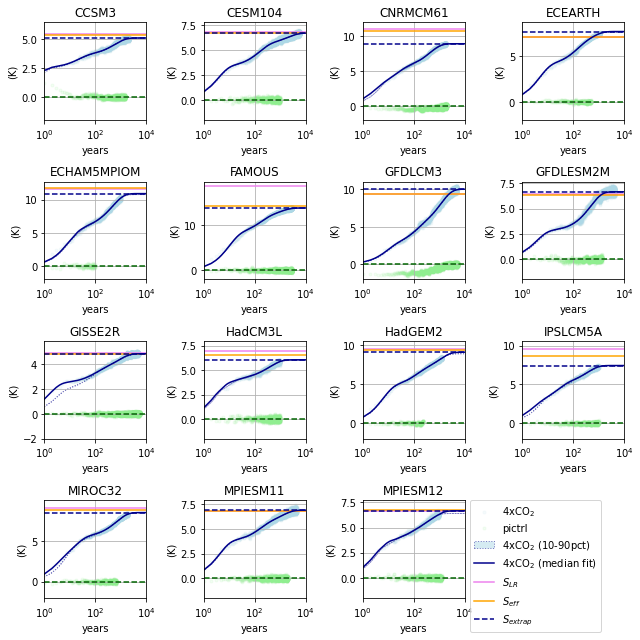

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(9)
fig.set_figwidth(9)

for j,i in enumerate(findex[0]):
  
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p0=axes[j].scatter(x_array,y_array,color='lightblue',marker='.',alpha=0.1)
  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.1)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')

  tmx=np.max([gsenslg[i],gsenslr[i],et_pct[i,1,-1]])

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,tmx+1])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='darkblue',linestyle='--')
  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='darkblue')
axes[15].set_visible(False)
plt.tight_layout()
axes[j].legend([p0,pc,p1,p5[0],p2,p3,p4], ['4xCO$_2$','pictrl','4xCO$_2$ (10-90pct)','4xCO$_2$ (median fit)','$S_{LR}$','$S_{eff}$','$S_{extrap}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_lrmip.png", bbox_inches='tight', dpi=300)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_lrmip.pdf", bbox_inches='tight')



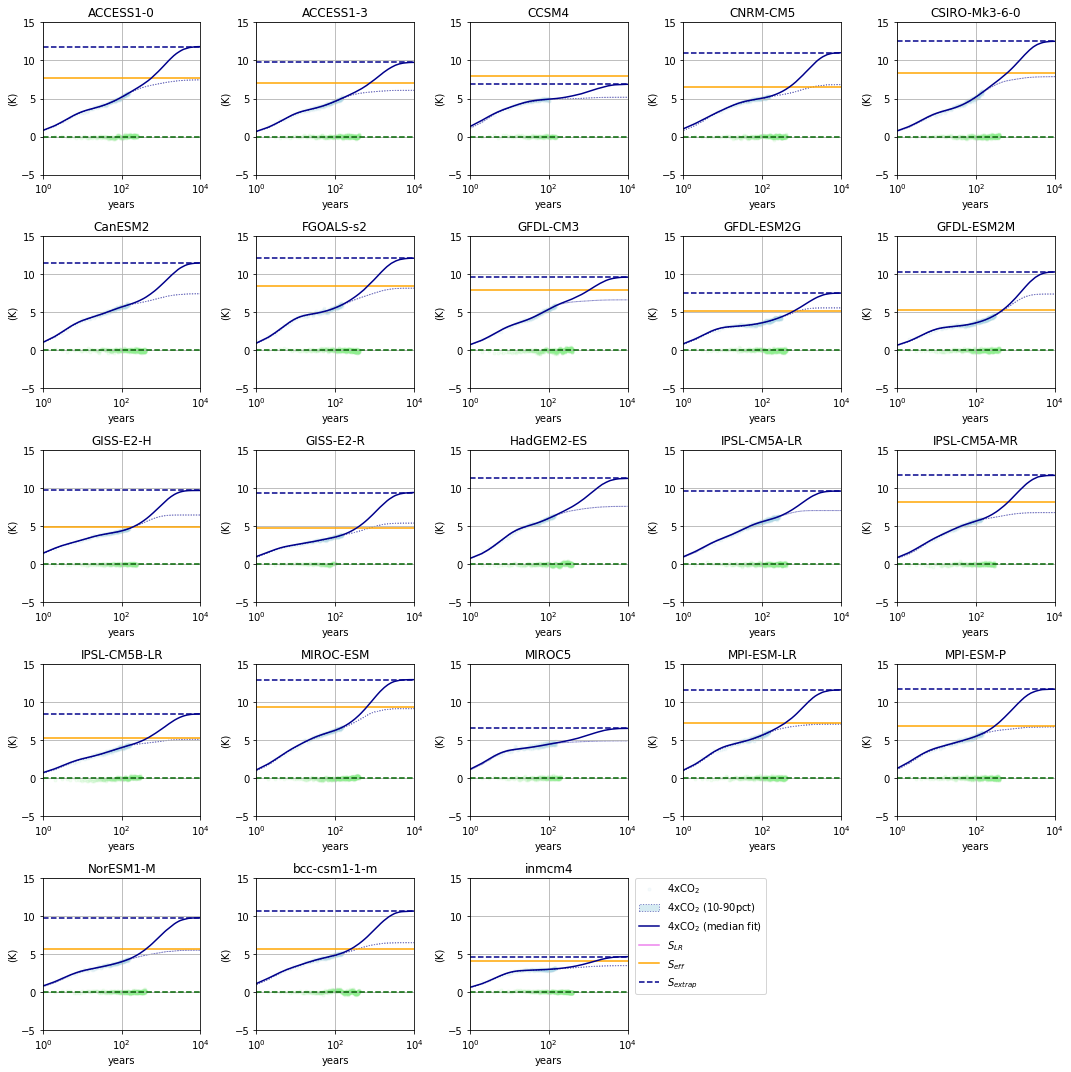

In [ ]:
fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(15)
fig.set_figwidth(15)

for j,i in enumerate(findex[1]):
    
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p0=axes[j].scatter(x_array,y_array,color='lightblue',marker='.',alpha=0.1)
  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.1)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')



  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-5,15])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='darkblue',linestyle='--')
  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='darkblue')

  
plt.tight_layout()
axes[j].legend([p0,p1,p5[0],p2,p3,p4], ['4xCO$_2$','4xCO$_2$ (10-90pct)','4xCO$_2$ (median fit)','$S_{LR}$','$S_{eff}$','$S_{extrap}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
axes[23].axis('off')
axes[24].axis('off')
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_cmip5.png", bbox_inches='tight', dpi=300)


In [ ]:
j

22

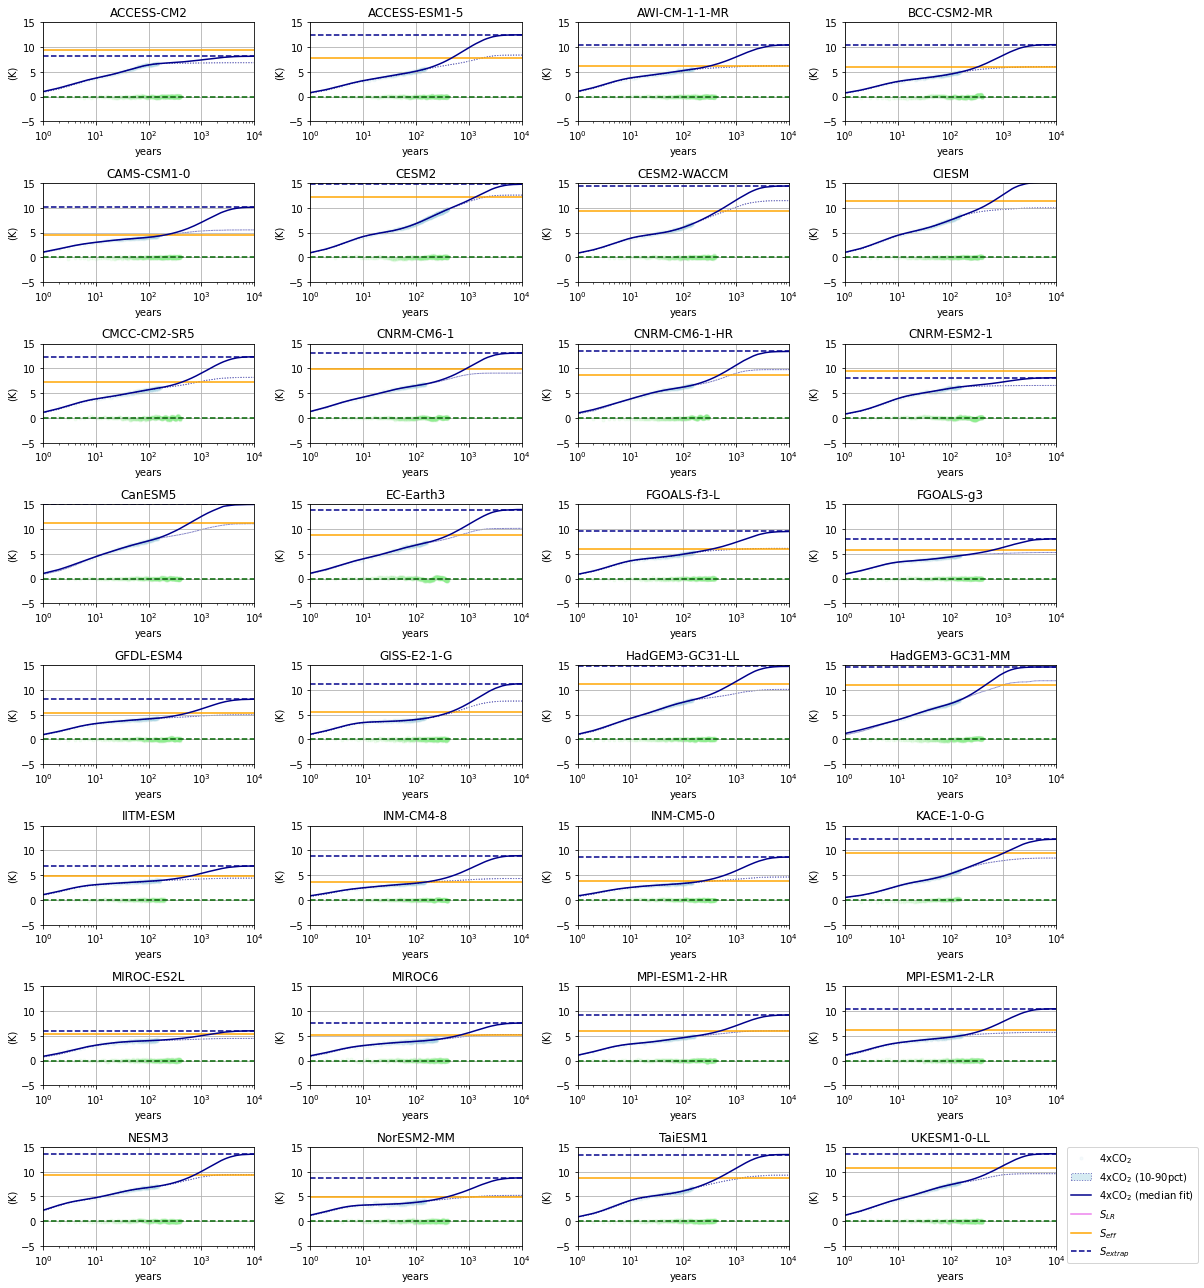

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=8)
axes = axes.flatten()

fig.set_figheight(18)
fig.set_figwidth(15)

for j,i in enumerate(findex[2]):
  
  
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p0=axes[j].scatter(x_array,y_array,color='lightblue',marker='.',alpha=0.1)
  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.1)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')



  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-5,15])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='darkblue',linestyle='--')
  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='darkblue')

plt.tight_layout()
axes[j].legend([p0,p1,p5[0],p2,p3,p4], ['4xCO$_2$','4xCO$_2$ (10-90pct)','4xCO$_2$ (median fit)','$S_{LR}$','$S_{eff}$','$S_{extrap}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_cmip6.png", bbox_inches='tight', dpi=300)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diffe

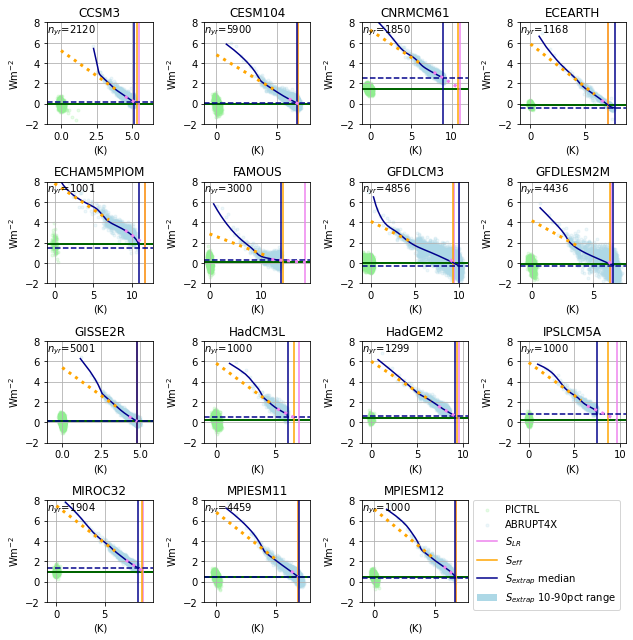

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(9)
fig.set_figwidth(9)

for i, j in enumerate(findex[0]):
  p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)


  axes[i].set_title(mdlslr[j])
  axes[i].set_xscale('linear')

  mxv=np.max([gsenslg[j],gsenslr[j],et_pct[j,1,-1]])
  axes[i].set_xlim([-1,mxv+1])
  axes[i].set_ylim([-2,8])

  #axes[i].axhline(0,color='k',linestyle='-')
  axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)

  p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LR}$')
  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$')

  axes[i].axhline(t_pct[j,1,-1],linestyle='--',color='darkblue',label='$S_{extrap} median$')
  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='-',color='darkblue')


  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='darkblue',linestyle='-')
  axes[i].plot([tmax[j]*0.85,gsenslg[j]],linear([tmax[j]*0.85,gsenslg[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt[j,:].mean().values),'violet',linewidth=3,linestyle=':')
  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle=':')
  axes[i].text(-1,7,'$n_{yr}$='+str(lents[j]))

  ellipse = Ellipse(xy=(et_pct[j,1,-1],t_pct[j,1,-1]), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
                        edgecolor='None', fc='lightblue', lw=2,linestyle='-')
  
  p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')

plt.tight_layout()
axes[15].set_visible(False)
axes[14].legend([pc,p4x,p1,p2,p3,p4], ['PICTRL','ABRUPT4X','$S_{LR}$','$S_{eff}$','$S_{extrap}$ median','$S_{extrap}$ 10-90pct range'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_lrmip.png", bbox_inches='tight', dpi=300)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_lrmip.pdf", bbox_inches='tight')






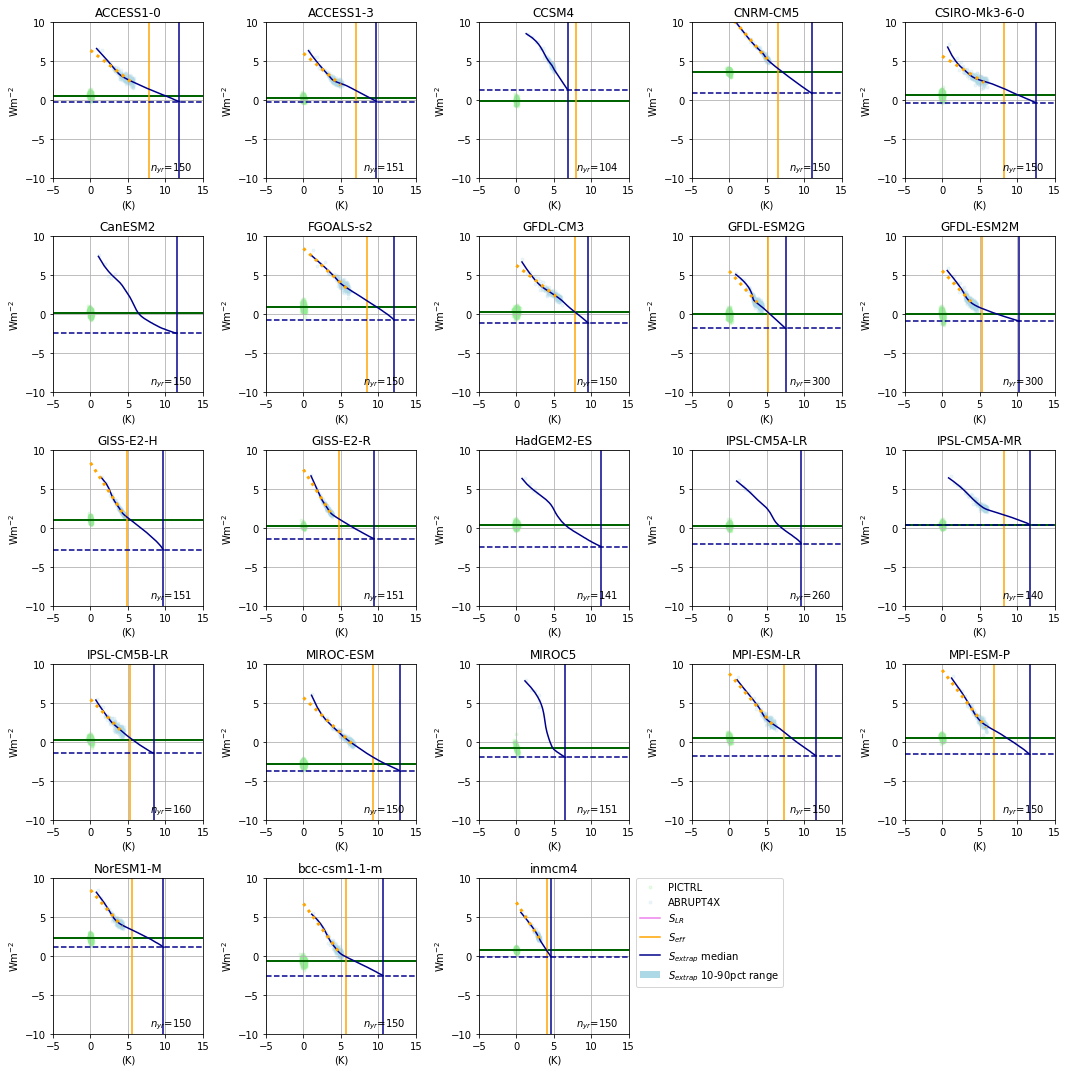

In [ ]:
fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(15)
fig.set_figwidth(15)

for i, j in enumerate(findex[1]):
  p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)


  axes[i].set_title(mdlslr[j])
  axes[i].set_xscale('linear')
  axes[i].set_xlim([-5,15])
  axes[i].set_ylim([-10,10])

  #axes[i].axhline(0,color='k',linestyle='-')
  axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)

  p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LR}$')
  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$')

  axes[i].axhline(t_pct[j,1,-1],linestyle='--',color='darkblue',label='$S_{extrap} median$')
  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='-',color='darkblue')


  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='darkblue',linestyle='-')
  axes[i].plot([tmax[j]*0.85,gsenslg[j]],linear([tmax[j]*0.85,gsenslg[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt[j,:].mean().values),'violet',linewidth=3,linestyle=':')
  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle=':')
  axes[i].text(8,-9,'$n_{yr}$='+str(lents[j]))

  ellipse = Ellipse(xy=(et_pct[j,1,-1],t_pct[j,1,-1]), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
                        edgecolor='None', fc='lightblue', lw=2,linestyle='-')
  
  p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')

plt.tight_layout()

axes[i].legend([pc,p4x,p1,p2,p3,p4], ['PICTRL','ABRUPT4X','$S_{LR}$','$S_{eff}$','$S_{extrap}$ median','$S_{extrap}$ 10-90pct range'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

axes[23].axis('off')
axes[24].axis('off')

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_cmip5.png", bbox_inches='tight', dpi=300)





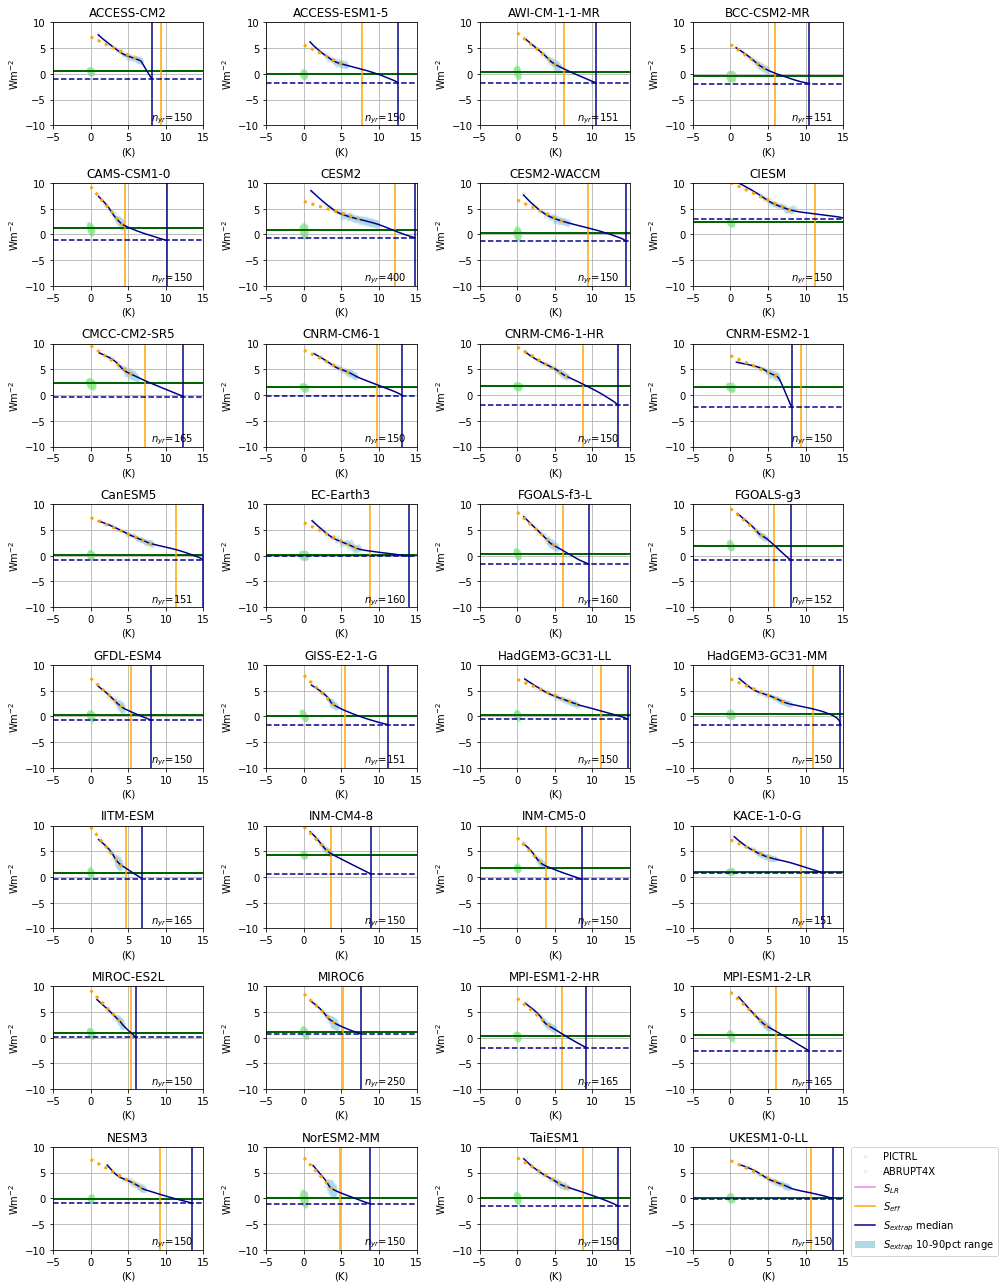

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=8)
axes = axes.flatten()

fig.set_figheight(18)
fig.set_figwidth(12)

for i, j in enumerate(findex[2]):
  p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)


  axes[i].set_title(mdlslr[j])
  axes[i].set_xscale('linear')
  axes[i].set_xlim([-5,15])
  axes[i].set_ylim([-10,10])

  #axes[i].axhline(0,color='k',linestyle='-')
  axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)

  p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LR}$')
  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$')

  axes[i].axhline(t_pct[j,1,-1],linestyle='--',color='darkblue',label='$S_{extrap} median$')
  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='-',color='darkblue')


  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='darkblue',linestyle='-')
  axes[i].plot([tmax[j]*0.85,gsenslg[j]],linear([tmax[j]*0.85,gsenslg[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt[j,:].mean().values),'violet',linewidth=3,linestyle=':')
  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle=':')
  axes[i].text(8,-9,'$n_{yr}$='+str(lents[j]))

  ellipse = Ellipse(xy=(et_pct[j,1,-1],t_pct[j,1,-1]), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
                        edgecolor='None', fc='lightblue', lw=2,linestyle='-')
  
  p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')

plt.tight_layout()

axes[i].legend([pc,p4x,p1,p2,p3,p4], ['PICTRL','ABRUPT4X','$S_{LR}$','$S_{eff}$','$S_{extrap}$ median','$S_{extrap}$ 10-90pct range'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_cmip6.png", bbox_inches='tight', dpi=300)





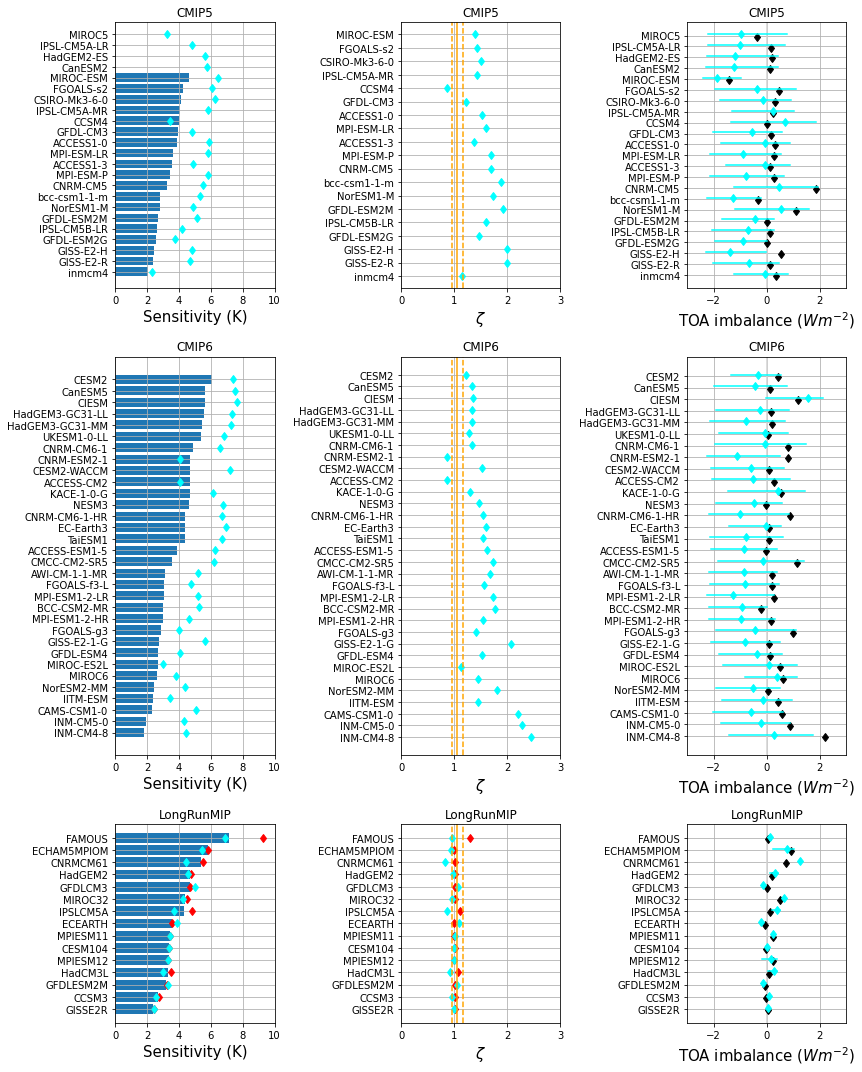

In [ ]:
fig, axes = plt.subplots(ncols=3,nrows=3, gridspec_kw={'height_ratios': [2,3,1.5]})
axes = axes.flatten()

fig.set_figheight(15)
fig.set_figwidth(12)
for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens":[gsenslr[ii,0]/2 for ii in indy],
                    "SensLG":[gsenslg[ii,0]/2 for ii in indy],
                    "Sens10":[et_pct[ii,0,-1]/2 for ii in indy],
                    "Sens50":[et_pct[ii,1,-1]/2 for ii in indy],
                    "Sens90":[et_pct[ii,2,-1]/2 for ii in indy],
                    "zetaLG":[gsenslg[ii,0]/gsenslr[ii,0] for ii in indy],
                    "zeta10":[et_pct[ii,0,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta50":[et_pct[ii,1,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta90":[et_pct[ii,2,-1]/gsenslr[ii,0] for ii in indy],
                    "cbal410":[t_pct[ii,0,-1]/2 for ii in indy],
                    "cbal450":[t_pct[ii,1,-1]/2 for ii in indy],
                    "cbal490":[t_pct[ii,2,-1]/2 for ii in indy],
                    "cbal50":[-net_cnt_100[ii]/2 for ii in indy],
                    "Sensc10":[etc_pct[ii,0,-1]/2 for ii in indy],
                    "Sensc50":[etc_pct[ii,1,-1]/2 for ii in indy],
                    "Sensc90":[etc_pct[ii,2,-1]/2 for ii in indy]})
  df_sorted= df.sort_values('Sens')
  # bar plot with matplotlib

  plt1=axes[3*i-3].barh('Model', 'Sens',data=df_sorted)
  yp=axes[3*i-3].get_yticks()
  axes[3*i-3].set_xlabel("Sensitivity (K)", size=15)
  axes[3*i-3].set_xlim([0,10])
  axes[3*i-3].plot(df_sorted.SensLG.to_numpy(),yp,'d',color='r')
  axes[3*i-3].set_title(gens[i])
  for j,jj in enumerate(indy):
    axes[3*i-3].plot([df_sorted.Sens10.to_numpy()[j],df_sorted.Sens90.to_numpy()[j]],[yp[j],yp[j]],'cyan')
    axes[3*i-3].plot([df_sorted.Sens50.to_numpy()[j]],yp[j],'cyan',marker='d')
 
  axes[3*i-3].grid()


  plt1=axes[3*i-2].barh('Model', 'zetaLG',data=df_sorted,ec='none',fc='none')
  yp=axes[3*i-2].get_yticks()
  axes[3*i-2].set_xlabel("$\zeta$", size=15)
  axes[3*i-2].set_xlim([0,3])
  axes[3*i-2].plot(df_sorted.zetaLG.to_numpy(),yp,'d',color='r')
  axes[3*i-2].set_title(gens[i])
  for j,jj in enumerate(indy):
    axes[3*i-2].plot([df_sorted.zeta10.to_numpy()[j],df_sorted.zeta90.to_numpy()[j]],[yp[j],yp[j]],'cyan')
    axes[3*i-2].plot([df_sorted.zeta50.to_numpy()[j]],yp[j],'cyan',marker='d')
  axes[3*i-2].axvline(0.96, color='orange',linestyle='--')
  axes[3*i-2].axvline(1.16, color='orange',linestyle='--')
  axes[3*i-2].axvline(1.06, color='orange',linestyle='-')
  axes[3*i-2].grid()

  plt1=axes[3*i-1].barh('Model', 'zetaLG',data=df_sorted,ec='none',fc='none')
  yp=axes[3*i-1].get_yticks()
  axes[3*i-1].set_xlabel("TOA imbalance $(Wm^{-2})$", size=15)
  axes[3*i-1].set_xlim([-3,3])
  axes[3*i-1].set_title(gens[i])
  axes[3*i-1].grid()

  axes[3*i-1].axvline(0, color='lightgrey',linestyle='-')
  for j,jj in enumerate(indy):
    #axes[3*i-1].plot([df_sorted.cbal10.to_numpy()[j],df_sorted.cbal90.to_numpy()[j]],[yp[j]-.1,yp[j]-.1],'black')
    axes[3*i-1].plot([df_sorted.cbal50.to_numpy()[j]],yp[j]-.1,'black',marker='d')
    axes[3*i-1].plot([df_sorted.cbal410.to_numpy()[j],df_sorted.cbal490.to_numpy()[j]],[yp[j]+0.1,yp[j]+0.1],'cyan')
    axes[3*i-1].plot([df_sorted.cbal450.to_numpy()[j]],yp[j]+0.1,'cyan',marker='d')




fig.tight_layout()
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/histo.png", bbox_inches='tight', dpi=300)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/histo.pdf", bbox_inches='tight')



In [ ]:
gsenslr[ii,0]/2
-net_cnt_100[ii,0]/2

0.0505717471241951

In [ ]:
for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens":[gsenslr[ii,0]/2 for ii in indy],
                    "SensLG":[gsenslg[ii,0]/2 for ii in indy],
                    "Sens10":[et_pct[ii,0,-1]/2 for ii in indy],
                    "Sens50":[et_pct[ii,1,-1]/2 for ii in indy],
                    "Sens90":[et_pct[ii,2,-1]/2 for ii in indy],
                    "zetaLG":[gsenslg[ii,0]/gsenslr[ii,0] for ii in indy],
                    "zeta10":[et_pct[ii,0,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta50":[et_pct[ii,1,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta90":[et_pct[ii,2,-1]/gsenslr[ii,0] for ii in indy],
                    "cbal410":[t_pct[ii,0,-1]/2 for ii in indy],
                    "cbal450":[t_pct[ii,1,-1]/2 for ii in indy],
                    "cbal490":[t_pct[ii,2,-1]/2 for ii in indy],
                    "cbal50":[-net_cnt_100[ii,0]/2 for ii in indy],
                    "Sensc10":[etc_pct[ii,0,-1]/2 for ii in indy],
                    "Sensc50":[etc_pct[ii,1,-1]/2 for ii in indy],
                    "Sensc90":[etc_pct[ii,2,-1]/2 for ii in indy],
                    "len4x":[len4x[ii,0].astype(int).astype(str) for ii in indy],})
  df['srng']=df.Sens50.round(2).astype(str).str.cat(df['Sens10'].round(2).astype(str).str.cat(df['Sens90'].round(2).astype(str),sep=','),sep=' (')+')'
  df['zrng']=df.zeta50.round(2).astype(str).str.cat(df['zeta10'].round(2).astype(str).str.cat(df['zeta90'].round(2).astype(str),sep=','),sep=' (')+')'
  df['cbrng']=df.cbal450.round(2).astype(str).str.cat(df['cbal410'].round(2).astype(str).str.cat(df['cbal490'].round(2).astype(str),sep=','),sep=' (')+')'
  df['s150rng']=df.Sensc50.round(2).astype(str).str.cat(df['Sensc10'].round(2).astype(str).str.cat(df['Sensc90'].round(2).astype(str),sep=','),sep=' (')+')'
  df2=df[['Model','len4x','Sens','SensLG','srng','zetaLG','zrng','cbrng','cbal50']].rename(columns={'Sens': '$S_{eff}$', 'SensLG': '$S_{LR}$', 'len4x': 'Years','srng': '$S_{extrap}','zrng': '$\zeta_{extrap}','cbrng':'$R^{4x}_{extrap}','cbal50':'$R^{CTRL}_0'})
  df2=df2.round(2)
  print(df2.to_latex(index=False, escape=False, na_rep='-'))


\begin{tabular}{llrrlrllr}
\toprule
      Model & Years &  $S_{eff}$ &  $S_{LR}$ &      $S_{extrap} &  zetaLG &  $\zeta_{extrap} &    $R^{4x}_{extrap} &  $R^{CTRL}_0 \\
\midrule
      CCSM3 &  2120 &       2.68 &      2.73 & 2.56 (2.55,2.55) &    1.02 & 0.96 (0.95,0.95) &    0.08 (0.07,0.09) &        -0.04 \\
    CESM104 &  5900 &       3.37 &      3.39 & 3.35 (3.35,3.35) &    1.01 &  1.0 (0.99,0.99) &    0.02 (0.01,0.03) &        -0.02 \\
   CNRMCM61 &  1850 &       5.42 &      5.51 & 4.48 (4.47,4.47) &    1.02 & 0.83 (0.83,0.83) &    1.26 (1.25,1.27) &         0.73 \\
    ECEARTH &  1168 &       3.55 &      3.55 & 3.86 (3.82,3.82) &    1.00 & 1.09 (1.08,1.08) & -0.21 (-0.26,-0.19) &        -0.06 \\
ECHAM5MPIOM &  1001 &       5.84 &      5.81 & 5.44 (5.37,5.37) &    0.99 & 0.93 (0.92,0.92) &    0.75 (0.25,1.04) &         0.92 \\
     FAMOUS &  3000 &       7.13 &      9.27 & 6.87 (6.86,6.86) &    1.30 & 0.96 (0.96,0.96) &    0.13 (0.07,0.14) &         0.03 \\
    GFDLCM3 &  4856 &   

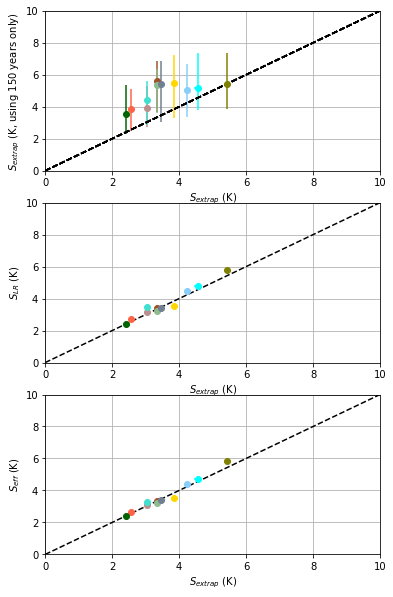

In [ ]:
from cycler import cycler
fig, axes = plt.subplots(ncols=1,nrows=3)
axes = axes.flatten()

markercycle = cycler(marker=['o', '+', 'x', '*', '.', 'X'])
colorcycle = cycler(color=['rosybrown','tomato','sienna','gold','olive','darkseagreen','darkgreen','turquoise','cyan','lightskyblue','slategrey','midnightblue','indigo','fuchsia','hotpink','crimson'])


fig.set_figheight(10)
fig.set_figwidth(6)

axes[0].set_prop_cycle(markercycle * colorcycle ) # gca()=current axis


uslr=[0,1,2,4,5,8,9,10,11,13,14]
yerr=np.abs(etc_pct[:,[0,2],-1].T-etc_pct[:,1,-1])
xerr=np.abs(et_pct[:,[0,2],-1].T-et_pct[:,1,-1])
for i,us in enumerate(uslr):
  axes[0].errorbar(et_pct[us,1,-1]/2,etc_pct[us,[1],-1]/2,yerr=[[yerr[0,us]/2],[yerr[1,us]/2]],xerr=[[xerr[0,us]/2],[xerr[1,us]/2]],label=mdlslr[us])
  #axes[0].text(et_pct[us,1,-1],etc_pct[us,[1],-1],mdlslr[us])
  axes[0].plot([0,30],[0,30],'k--')
  axes[0].set_xlabel('$S_{extrap}$ (K)')
  axes[0].set_ylabel('$S_{extrap}$ (K, using 150 years only)')
  axes[0].set_xlim([0,10])
  axes[0].set_ylim([0,10])

  axes[0].grid()
  #axes[0].legend(handles=p1[0], ncol=2,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  axes[1].set_prop_cycle(markercycle * colorcycle ) # gca()=current axis


for i,us in enumerate(uslr):
  axes[1].errorbar(et_pct[us,1,-1]/2,gsenslg[us]/2,yerr=[[0],[0]],xerr=[[xerr[0,us]/2],[xerr[1,us]/2]],label=mdlslr[us],marker='o',fillstyle='full')

  #axes[1].text(et_pct[us,1,-1],gsenslg[us],mdlslr[us])
axes[1].plot([0,30],[0,30],'k--')
axes[1].set_xlabel('$S_{extrap}$ (K)')
axes[1].set_ylabel('$S_{LR}$ (K)')
axes[1].set_xlim([0,10])
axes[1].set_ylim([0,10])

axes[1].grid()
axes[2].set_prop_cycle(markercycle * colorcycle ) # gca()=current axis

for i,us in enumerate(uslr):
  axes[2].errorbar(et_pct[us,1,-1]/2,gsenslr[us]/2,yerr=[[0],[0]],xerr=[[xerr[0,us]/2],[xerr[1,us]/2]],label=mdlslr[us],marker='o',fillstyle='full')

  #axes[1].text(et_pct[us,1,-1],gsenslg[us],mdlslr[us])
axes[2].plot([0,30],[0,30],'k--')
axes[2].set_xlabel('$S_{extrap}$ (K)')
axes[2].set_ylabel('$S_{eff}$ (K)')
axes[2].set_xlim([0,10])
axes[2].set_ylim([0,10])

axes[2].grid()

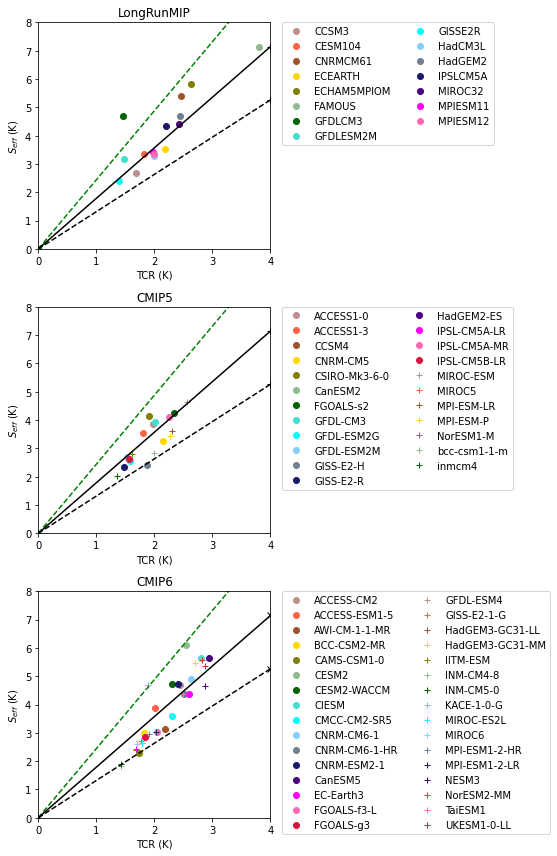

In [ ]:
from cycler import cycler
fig, axes = plt.subplots(ncols=1,nrows=3)
axes = axes.flatten()


markercycle = cycler(marker=['o', '+', 'x', '*', '.', 'X'])
colorcycle = cycler(color=['rosybrown','tomato','sienna','gold','olive','darkseagreen','darkgreen','turquoise','cyan','lightskyblue','slategrey','midnightblue','indigo','fuchsia','hotpink','crimson'])



fig.set_figheight(12)
fig.set_figwidth(4)
p1=[None]*3
for i,indy in enumerate(findex):
  p1[i]=[]
  axes[i].set_prop_cycle(markercycle*colorcycle  ) # gca()=current axis
  for j,jj in enumerate(indy):
    #axes[i].text(etcr_pct[jj,1],gsenslr[jj,0]/2,mdlslr[jj],fontsize=8)
    p1[i].append(axes[i].plot(ttcr[jj],gsenslr[jj]/2,label=mdlslr[jj],linestyle='none')[0])
    #axes[i].plot(ttcr[jj],gsenslg[jj]/2,label=mdlslr[jj],linestyle='none',marker='+')
  axes[i].set_ylim([0,8])
  axes[i].set_xlim([0,4])
  axes[i].set_xlabel('TCR (K)')
  axes[i].set_ylabel('$S_{eff}$ (K)')
  axes[i].set_title(gens[i])
  axes[i].plot([0,4],[0,4/0.41],color='g',linestyle='--')
  axes[i].plot([0,4],[0,4/0.76],color='k',linestyle='--')
  axes[i].plot([0,4],[0,4/0.56],color='k')

plt.tight_layout()
for i,indy in enumerate(findex):
  axes[i].legend(handles=p1[i], ncol=2,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
t_fast=pfit[:,1,0:3]*(1-np.exp(-140/pfit[:,1,3:6]))
t_fast.shape

(75, 3)

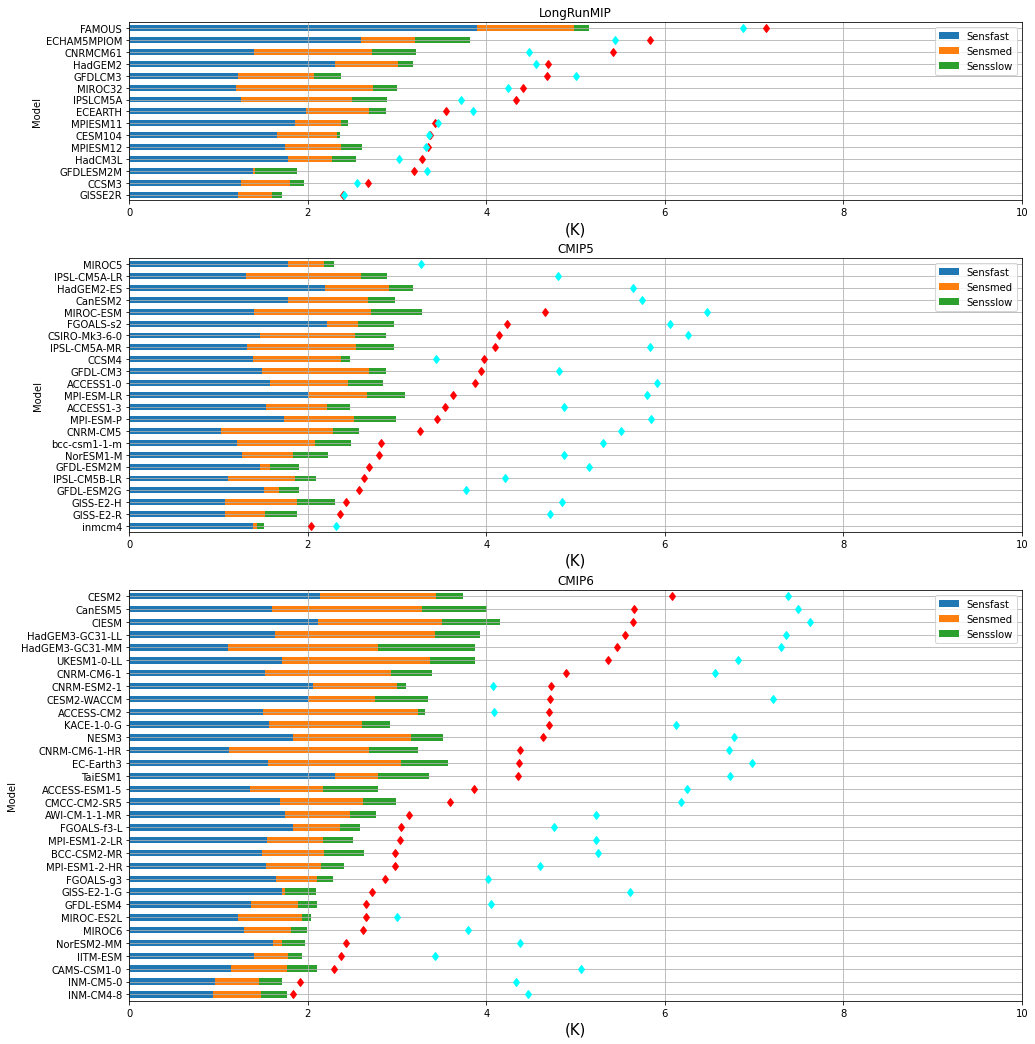

In [ ]:
fig, axes = plt.subplots(ncols=1,nrows=3, gridspec_kw={'height_ratios': [1.3,2,3]})
axes = axes.flatten()

fig.set_figheight(18)
fig.set_figwidth(16)
for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens":[gsenslr[ii,0]/2 for ii in indy],
                    "Sensfast":[t_fast[ii,0]/2 for ii in indy],
                    "Sensmed":[t_fast[ii,1]/2 for ii in indy],
                    "Sensslow":[t_fast[ii,2]/2 for ii in indy],
                    "Sens10":[et_pct[ii,0,-1]/2 for ii in indy],
                    "Sens50":[et_pct[ii,1,-1]/2 for ii in indy],
                    "Sens90":[et_pct[ii,2,-1]/2 for ii in indy],})
  df_sorted= df.sort_values('Sens')

  # bar plot with matplotlib

  #plt1=axes[i].barh('Model', 'Sensfast', data=df_sorted)
  df_sorted.set_index('Model').drop(columns=['Sens','Sens10','Sens50','Sens90']).plot.barh(stacked=True,ax=axes[i]);
  yp=axes[i].get_yticks()
  axes[i].set_xlabel("Sensitivity (K)", size=15)
  axes[i].set_xlim([0,10])
  axes[i].set_title(gens[i])
  yp=axes[i].get_yticks()
  axes[i].set_xlabel("(K)", size=15)
  axes[i].set_xlim([0,10])
  axes[i].plot(df_sorted.Sens.to_numpy(),yp,'d',color='r')
  for j,jj in enumerate(indy):
    axes[i].plot([df_sorted.Sens10.to_numpy()[j],df_sorted.Sens90.to_numpy()[j]],[yp[j],yp[j]],'cyan')
    axes[i].plot([df_sorted.Sens50.to_numpy()[j]],yp[j],'cyan',marker='d')
 
  axes[i].grid()
